In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

print(os.getcwd())

g:\My Drive\1. EIT Digital master\Estland\Semester 1\Computer vision\its8030-2021-hw2


In [4]:
os.chdir("/Users/javiergalindos/OneDrive/OneDrive - Universidad Politécnica de Madrid/Documentos/MSc DM/2ºDM/Computer Vision/Code/its8030-2021-hw2")

(320, 249)


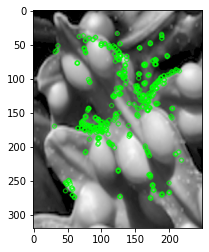

(<matplotlib.image.AxesImage at 0x1b01a3edfd0>, None)

In [2]:
### checking etalon features

img = cv2.imread('Etalons/Fucus/etalon_fucus_5.png',0)
print(img.shape)


# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

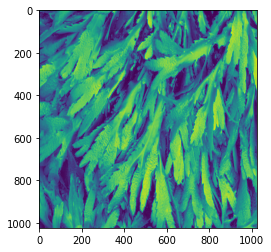

[['Zos' 'Fuc' 'FucZos' 'Fuc']
 ['Fuc' 'Fuc' 'FucFurZos' 'Fuc']
 ['FucZos' 'Fur' 'Fur' 'Fuc']
 ['Fuc' 'FucFur' 'Fuc' 'FurZos']]


In [59]:
# Read the query image as query_img
# and train image This query image
# is what you need to find in train image
# Save it in the same directory
# with the name image.jpg 
#query_img_bw = cv2.imread('Etalons/Fucus/etalon_fucus_5.png',0)
#train_img_bw = cv2.imread('Processed images/Fucus/Fucus_0.jpg',0)
#train_img_bw = cv2.imread('Processed images/Zostera marina/zostera_marina_3.jpg',0)
#train_img_bw = cv2.imread('Processed images/Furcellaria lumbricalis/furcellaria_lumbricalis_2.jpg')
train_img_bw = cv2.imread('Processed images/Fucus/Fucus_13.jpg',0)

plt.imshow(train_img_bw),plt.show()
#print(train_img_bw.shape)
  
# Convert it to grayscale
# query_img_bw = cv2.cvtColor(query_img,cv2.COLOR_BGR2GRAY)
# train_img_bw = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
  
# Initialize the ORB detector algorithm
orb = cv2.ORB_create()

######
# splitting the grid like a hacker
#
######
grid_per_side = 4
step = int(train_img_bw.shape[0]/grid_per_side) # 4x4 matrix

lowe_ratio = 0.6
good_match_thresh = 0
grid_class = np.empty(shape = (grid_per_side, grid_per_side), dtype='object')

classes = ['Fuc', 'Fur', 'Zos']


for x_coord in range(0, train_img_bw.shape[0], step):
    begin_x = x_coord
    end_x = x_coord + step
    for y_coord in range(0, train_img_bw.shape[1], step):
        begin_y = y_coord
        end_y = y_coord + step
        
        #step through every grid cell
        img_patch = train_img_bw[begin_x:end_x, begin_y:end_y]
        
        class_for_patch = []
        #now check this image patch with all the etalons, return the max class (or nothing) per img patch
        for folder in os.listdir('./Etalons'):
            #get to a particular class of etalon
            etalon_dir_path = os.path.join('./Etalons', folder)
            
            max_goodies = 0
            
            for etalon_img_path in os.listdir(etalon_dir_path):
                
                etalon_fullpath = os.path.join(etalon_dir_path, etalon_img_path)
                
                # Now detect the keypoints and compute
                # the descriptors for the query image
                # and train image
                query_img_bw = cv2.imread(etalon_fullpath,0)
                #print(etalon_fullpath)
                
                queryKeypoints, queryDescriptors = orb.detectAndCompute(query_img_bw,None)
                trainKeypoints, trainDescriptors = orb.detectAndCompute(img_patch,None)
                
                # Initialize the Matcher for matching
                # the keypoints and then match the
                # keypoints

                #matcher = cv2.DescriptorMatcher_create('BruteForce-L1') #BruteForce = L2, BruteForce-L1
                matcher = cv2.BFMatcher(cv2.NORMCONV_FILTER)
                matches = matcher.knnMatch(queryDescriptors,trainDescriptors, k=2)
                
                # draw the matches to the final image
                # containing both the images the drawMatches()
                # function takes both images and keypoints
                # and outputs the matched query image with
                # its train image
                # final_img = cv2.drawMatchesKnn(query_img_bw, queryKeypoints,
                # img_patch, trainKeypoints, matches[:50],None)
                good = [[m] for m, n in matches if m.distance < lowe_ratio*n.distance]
                # img3 = cv2.drawMatchesKnn(query_img_bw,queryKeypoints,img_patch,trainKeypoints,good, None, flags=2)
                max_goodies += len(good)

            class_for_patch.append(max_goodies)
        #print((class_for_patch))
        if np.max(class_for_patch) > good_match_thresh:
            #deal with multiple maxima at one point
            m = [i for i,j in enumerate(class_for_patch) if j==np.max(class_for_patch)]
           
            pred_patch_class = ''
            for i in m:
                pred_patch_class += classes[i]

        else:
            pred_patch_class = 'None'
            
        #print(pred_patch_class)
        grid_class[int(begin_x/step),int(begin_y/step)] = pred_patch_class

print(grid_class)
        
        

In [11]:
### Getting a score


# This time, we will use BFMatcher.knnMatch() to get k best matches. 
# In this example, we will take k=2 so that we can apply ratio test 
# explained by D.Lowe in his paper. 

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

os.chdir("g:\\My Drive\\1. EIT Digital master\\Estland\\Semester 1\\Computer vision\\its8030-2021-hw2\\")

def FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Fucus', lowe_ratio = 0.7, method = 'ORB'):
    thresh_good = 2 
    
    etalon_dir_path = './etalons/'
    process_img_path = './Processed images/'

    etalon_dir_path = os.path.join(etalon_dir_path, classtype_etalon)
    process_img_path = os.path.join(process_img_path, classtype_train)

    results = np.zeros(shape=(len(os.listdir(process_img_path)), len(os.listdir(etalon_dir_path))))

    row = 0
    for img_path in os.listdir(process_img_path):
        
        folder_path_img= os.path.join(process_img_path, img_path)
        img = cv2.imread(folder_path_img,0)

        col = 0
        for etalon_path in os.listdir(etalon_dir_path):
            
            etalon_path_img= os.path.join(etalon_dir_path, etalon_path)
            etalon = cv2.imread(etalon_path_img,0)

            good = []
            
            if method == 'ORB':
                finder = cv2.ORB_create()
                # find the keypoints and descriptors with ORB
                kp1, des1 = finder.detectAndCompute(etalon,None)
                kp2, des2 = finder.detectAndCompute(img,None)
                
                # BFMatcher with hamming >> L2
                bf = cv2.BFMatcher(cv2.NORM_HAMMING)
                matches = bf.knnMatch(des1,des2, k=2)
                # Apply ratio test
                good = [[m] for m, n in matches if m.distance < lowe_ratio*n.distance]
                if len(good) > thresh_good:
                    #img3 = cv2.drawMatchesKnn(etalon,kp1,img,kp2,good, None, flags=2)
                    #fname = 'output_%s_%s_.png' % (img_path, etalon_path)
                    #cv2.imwrite(fname, img3)
                    # font = cv2.FONT_HERSHEY_SIMPLEX
                    results[row][col] = len(good)

            if method == 'SIFT':
                # Initiate SIFT detector
                sift = cv2.SIFT_create()
                # find the keypoints and descriptors with SIFT
                kp1, des1 = sift.detectAndCompute(etalon,None)
                kp2, des2 = sift.detectAndCompute(img,None)
                
                length = 0
                
                # FLANN parameters
                FLANN_INDEX_KDTREE = 1
                index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
                search_params = dict(checks=50)   # or pass empty dictionary
                flann = cv2.FlannBasedMatcher(index_params,search_params)
                matches = flann.knnMatch(des1,des2,k=2)
                # Need to draw only good matches, so create a mask

                good = []
                # ratio test as per Lowe's paper
                for m,n in (matches):
                    if m.distance <lowe_ratio*n.distance:
                        good.append(m)
                
                if len(good) > thresh_good:
                    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

                    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
                    matchesMask = mask.ravel().tolist()

                    h,w = etalon.shape
                    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                    dst = cv2.perspectiveTransform(pts,M)

                    img = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
                    draw_params = dict(matchColor = (0,255,0),
                                        singlePointColor = (255,0,0),
                                        matchesMask = matchesMask,
                                        flags = cv2.DrawMatchesFlags_DEFAULT)
                    fname = 'output_%s_%s_.png' % (img_path, etalon_path)
                    img3 = cv2.drawMatches(etalon,kp1,img,kp2,good,None,**draw_params)   
                    cv2.imwrite(fname, img3)
                    # font = cv2.FONT_HERSHEY_SIMPLEX
                    results[row][col] = length



            # msg1 = 'using %s with lowe_ratio %.2f' % (method, lowe_ratio)
            # msg2 = 'there are %d good matches' % (len(good))


            # print(msg1)
            # print(msg2)
            # cv2.putText(img3,msg1,(10, 250), font, 0.5,(255,255,255),1,cv2.LINE_AA)
            # cv2.putText(img3,msg2,(10, 270), font, 0.5,(255,255,255),1,cv2.LINE_AA)


            col += 1
            #plt.imshow(img3),plt.show()
        row += 1
    return results

In [12]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Fucus', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\core\src\matmul.dispatch.cpp:531: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'


In [4]:
results

array([[  7.,   0.,   0.],
       [695.,   0.,   0.],
       [ 10.,   0., 517.],
       [  6.,   7.,   0.],
       [  7.,   0.,   0.],
       [  4.,   0.,   3.],
       [  5.,   0.,   6.],
       [  0.,   0.,   0.],
       [  5.,   0.,   0.],
       [  0.,   0.,   0.],
       [  4.,   0.,   3.],
       [  4.,   0.,   0.],
       [  5.,   0.,   0.],
       [  5.,   0.,   0.],
       [  6.,   0.,   4.],
       [  6.,   0.,   4.],
       [  3.,   0.,   3.],
       [  3.,   0.,   0.],
       [  6.,   0.,   4.],
       [  0.,   0.,   0.],
       [  0.,   0.,   5.],
       [  0.,   0.,   4.],
       [  0.,   0.,   0.],
       [  7.,   0.,   0.],
       [  5.,   0.,   0.],
       [  0.,   0.,   0.],
       [  7.,   0.,   3.],
       [  5.,   0.,   4.],
       [  9.,   0.,   0.],
       [  4.,   0.,   0.],
       [ 10.,   0.,   7.],
       [  0.,   0.,   3.],
       [  9.,   0.,   4.],
       [  4.,   0.,   0.],
       [  9.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   3.,   3.],
 

In [5]:
#how many good classifications do we consider to be good?
our_threshold = 2

max_vals = (np.amax(results,1))
good_classifc = np.count_nonzero((max_vals > our_threshold))

ratio = round(good_classifc / results.shape[0],2)
ratio

0.85

In [67]:
def FDpredict(img_select = './Processed images/Fucus/Fucus_0.jpg', lowe_ratio = 0.7, method = 'ORB' ):
    etalon_dir_path = './Etalons/'
    im_results = np.zeros(shape=(1,10)) #10 because we dont know the exact amount of etalons
    final_results = np.zeros(shape=(1,3))

    img = cv2.imread(img_select,0)
    
    col_final = 0
    for etalon_folder in os.listdir(etalon_dir_path):
        col_im = 0

        class_etalon = os.path.join(etalon_dir_path, etalon_folder)
        
        for etalon_path in os.listdir(class_etalon):
            
            etalon_path_img= os.path.join(class_etalon, etalon_path)
            etalon = cv2.imread(etalon_path_img,0)


            if method == 'ORB':
                finder = cv2.ORB_create()

            # find the keypoints and descriptors with SIFT
            kp1, des1 = finder.detectAndCompute(etalon,None)
            kp2, des2 = finder.detectAndCompute(img,None)

            # BFMatcher with default params
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(des1,des2, k=2)

            # Apply ratio test
            good = []

            good = [[m] for m, n in matches if m.distance < lowe_ratio*n.distance]

            # msg1 = 'using %s with lowe_ratio %.2f' % (method, lowe_ratio)
            # msg2 = 'there are %d good matches' % (len(good))

            # img3 = cv2.drawMatchesKnn(etalon,kp1,img,kp2,good, None, flags=2)

            # font = cv2.FONT_HERSHEY_SIMPLEX

            im_results[0][col_im] = len(good)
            # print(msg1)
            # print(msg2)
            # cv2.putText(img3,msg1,(10, 250), font, 0.5,(255,255,255),1,cv2.LINE_AA)
            # cv2.putText(img3,msg2,(10, 270), font, 0.5,(255,255,255),1,cv2.LINE_AA)
            # fname = 'output_%s_%.2f.png' % (method, lowe_ratio)
            # cv2.imwrite(fname, img3)
            col_im += 1
            #plt.imshow(img3),plt.show()
        final_results[0][col_final] = np.sum(im_results)/len(os.listdir(etalon_dir_path)) #get average so that it is not biased with number of etalons
        col_final += 1
    return final_results

In [70]:
os.chdir("g:\\My Drive\\1. EIT Digital master\\Estland\\Semester 1\\Computer vision\\its8030-2021-hw2\\")


img = './Processed images/Fucus/Fucus_13.jpg'
results = FDpredict(img_select = img, lowe_ratio = 0.7, method = 'ORB' )
print(results)

if(np.argmax(results) == 0):
    print('Predicted %s as: Fucus' %img )


elif(np.argmax(results) == 1):
    print('Predicted %s as: Furcellaria lumbricalis' %img )

else:
    print('Predicted %s as: Zostera marina' %img )

[[1.         1.33333333 1.        ]]
Predicted ./Processed images/Fucus/Fucus_13.jpg as: Furcellaria lumbricalis


In [10]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Fucus', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

[  6. 694. 517.   8.   7.   4.   6.   4.   5.   0.   4.   0.   4.   0.
   8.   8.   3.   0.   6.   0.   8.   4.   3.   5.   3.   0.   7.   4.
   7.   5.  10.   4.   9.   3.   9.   0.   3.   3.   3.   9.   5.   5.
 227.   6.   3.   5.   0.   6.   3.   3.   6.   5.   6.   5.   5.]
30.418181818181818


In [12]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Furcellaria lumbricalis', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

[0. 5. 4. 6. 0. 3. 3. 3. 6. 0. 4. 4. 6. 5. 4. 3. 4. 3. 0. 0. 7. 0. 4. 3.
 8. 5. 3. 5. 4. 3. 0. 5. 5. 3. 0. 5. 6. 3. 3. 4. 3. 0. 8. 4.]
3.5


In [9]:
results = FDBaseline(classtype_etalon = 'Fucus', classtype_train = 'Zostera marina', lowe_ratio = 0.7, method = 'SIFT')
print(np.amax(results,1))
print(np.mean(np.amax(results,1)))

[ 5.  4.  0.  6.  3.  5.  5.  0.  0.  5.  3.  4.  5.  3.  7.  4.  0.  0.
  4.  3.  7.  3.  5.  0.  3.  3.  0.  3.  3.  0.  3.  0.  4.  0.  3.  0.
  6.  3.  5.  3.  4.  5.  4.  5.  4. 12.  3.  3.  0.]
3.2653061224489797
